# Heart Failure Prediction - Linear Model

The aim of this project is to create a linear model capable of predicting heart failure according to differents metrics such as the age, the sex, the or cholesterol level of a patient.

## I - All imports

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## II - Data Exploratory Analysis

In [4]:
df = pd.read_csv('./sample_data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### A - Metadata

#### Shape

In [5]:
df.shape

(918, 12)

`Note`: We see here that the dataset contain 918 elements which is good. We don't need to worry about overfitting

#### Features overall

In [ ]:
df.dtypes

,0
Age,int64
Sex,string[python]
ChestPainType,string[python]
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,string[python]
MaxHR,int64
ExerciseAngina,string[python]
Oldpeak,float64


In [ ]:
len(df.dtypes)

12

1. **Age**: Age of the patient --> Years
2. **Sex**: Sex of the patient --> M or F (Male or Female)
3. **ChestPainType**: Chest Pain Type --> A: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
4. **RestingBP**: Resting Blood Pressure --> mm Hg
5. **Cholesterol**: Serum Cholesterol --> mm/dl
6. **FastingBS**: Fasting Blood Sugar --> 1: if FastingBS > 120 mg/dl, 0: otherwise
7. **RestingECG**: Resting Electrocardiogram Results --> Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. **MaxHR**: Maximum Heart Rate Achieved --> Numeric value between 60 and 202
9. **ExerciseAngina**: Exercise-induced Angina --> Y: Yes, N: No
10. **Oldpeak**: Oldpeak = ST --> Numeric value measured in depression
11. **ST_Slope**: The slope of the peak exercise ST segment --> Up: upsloping, Flat: flat, Down: downsloping
12. **HeartDisease**: Output Class --> 1: heart disease, 0: Normal


#### Categorical features

In [ ]:
# Transform object column to string
categorical_col = df.select_dtypes(include="object").columns
df[categorical_col]=df[categorical_col].astype("string")

# List them
categorical_col=df.select_dtypes("string").columns.to_list()
categorical_col

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

#### Numerical features

In [ ]:
numerical_col=df.select_dtypes(exclude="string").columns.to_list()
numerical_col

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

`Note`: We see here that the number of categorical and numerical features is close, which is good.

### B - Nb. Nulls, NaN or N/A

#### Number of null / NA values

In [ ]:
df.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [ ]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


Since we don't have null or NaN values, we don't need to remove the concerned rows or to impute any values.

Later in this Google Colab, we will add some NaN values (See outlier section). So we will need to practice imputation by substituting the missing values in the dataset.

### C - Features values distributions, scaling & outliers

#### Feature values distributions

In [ ]:
fig=px.histogram(df,
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribution of Heart Diseases",
                 barmode="group")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="Sex",
                 hover_data=df.columns,
                 title="Sex Ratio in the Data")
fig.show()

With those graphs, we notice in this dataset that we have a higher amount of men than woman.

Furthermore, the ratio between men without heart disease and men with heart disease is higher the ratio of woman with heart disease.

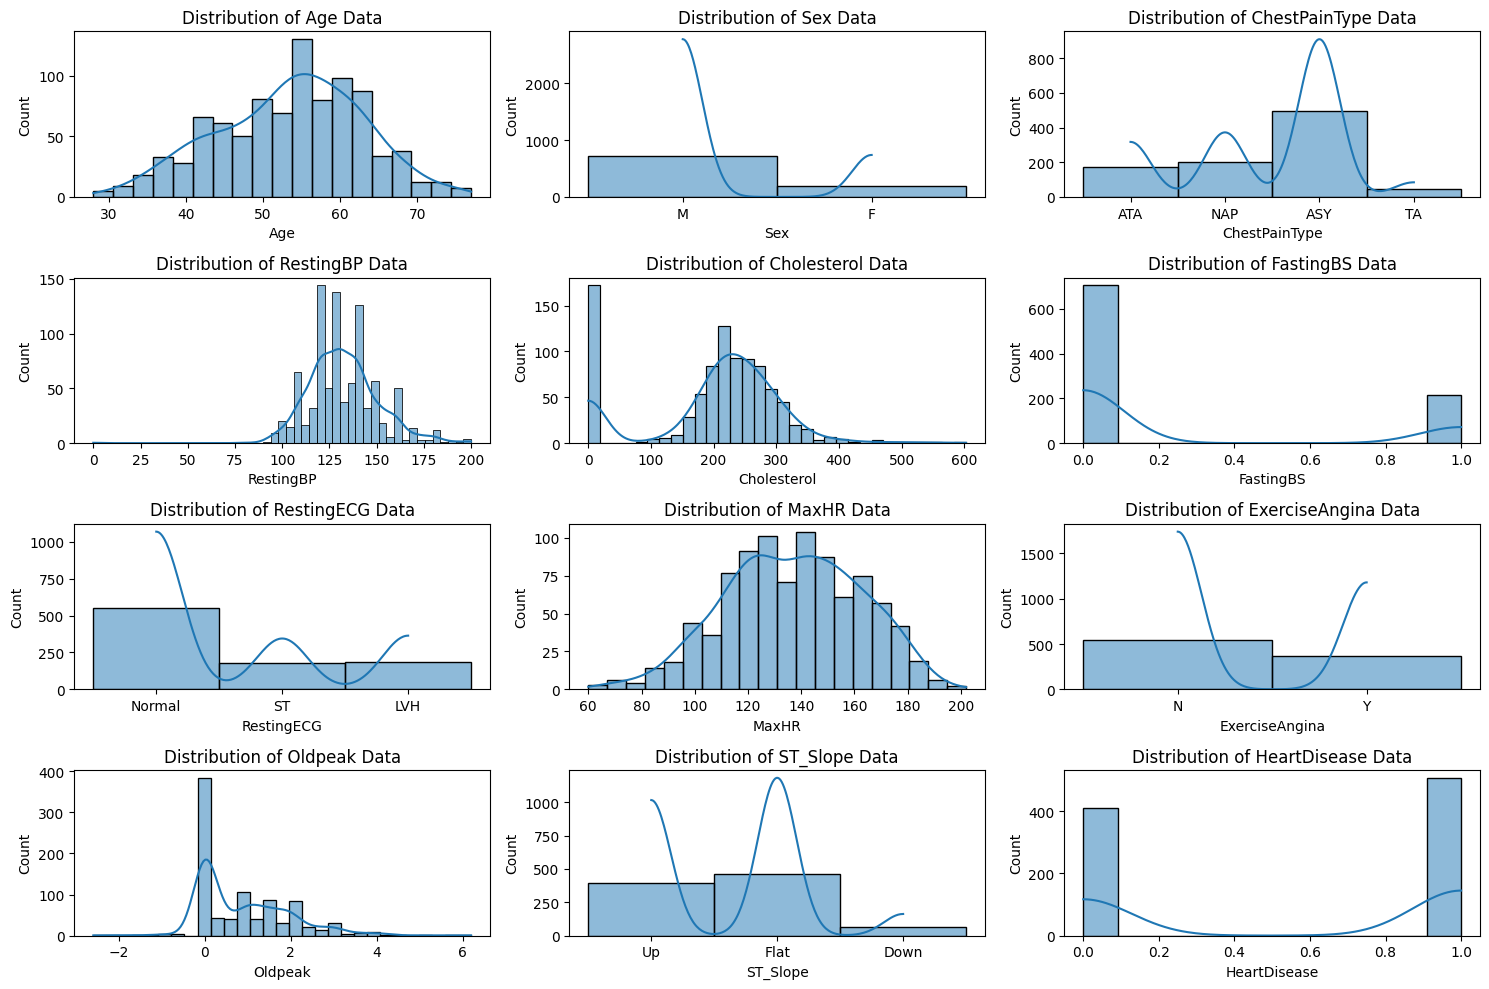

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()


In those graphs we mainly notice:
- They is a lot of Cholesterol=0 values which is weird since 0 mm/dL of cholesterol is physiologically impossible. It could be a data artifact (invalid/missing data)
- The dataset contain more males patients than female
- Most patients do not have exercise‐induced angina and have normal resting ECG
- Oldpeak is usually near 0, but goes up for some patients, consistent with varying degrees of ST depression
- The HeartDisease variable is relatively balanced, which is helpful for modeling

#### Outliers


We previously noticed a potential outlier thanks to the previous distributions graph for the **cholesterol feature**.

In [ ]:
num_zeros = (df['Cholesterol'] == 0).sum()
num_zeros

172

Since it is phylosiologically impossible, we will treat the zeros as missing and then, impute those NaN values using mean.

In [ ]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = np.nan
cholesterol_nans = df['Cholesterol'].isna().sum()
cholesterol_nans

172

In [ ]:
imputer = SimpleImputer(strategy='mean')
df[['Cholesterol']] = imputer.fit_transform(df[['Cholesterol']])

[]

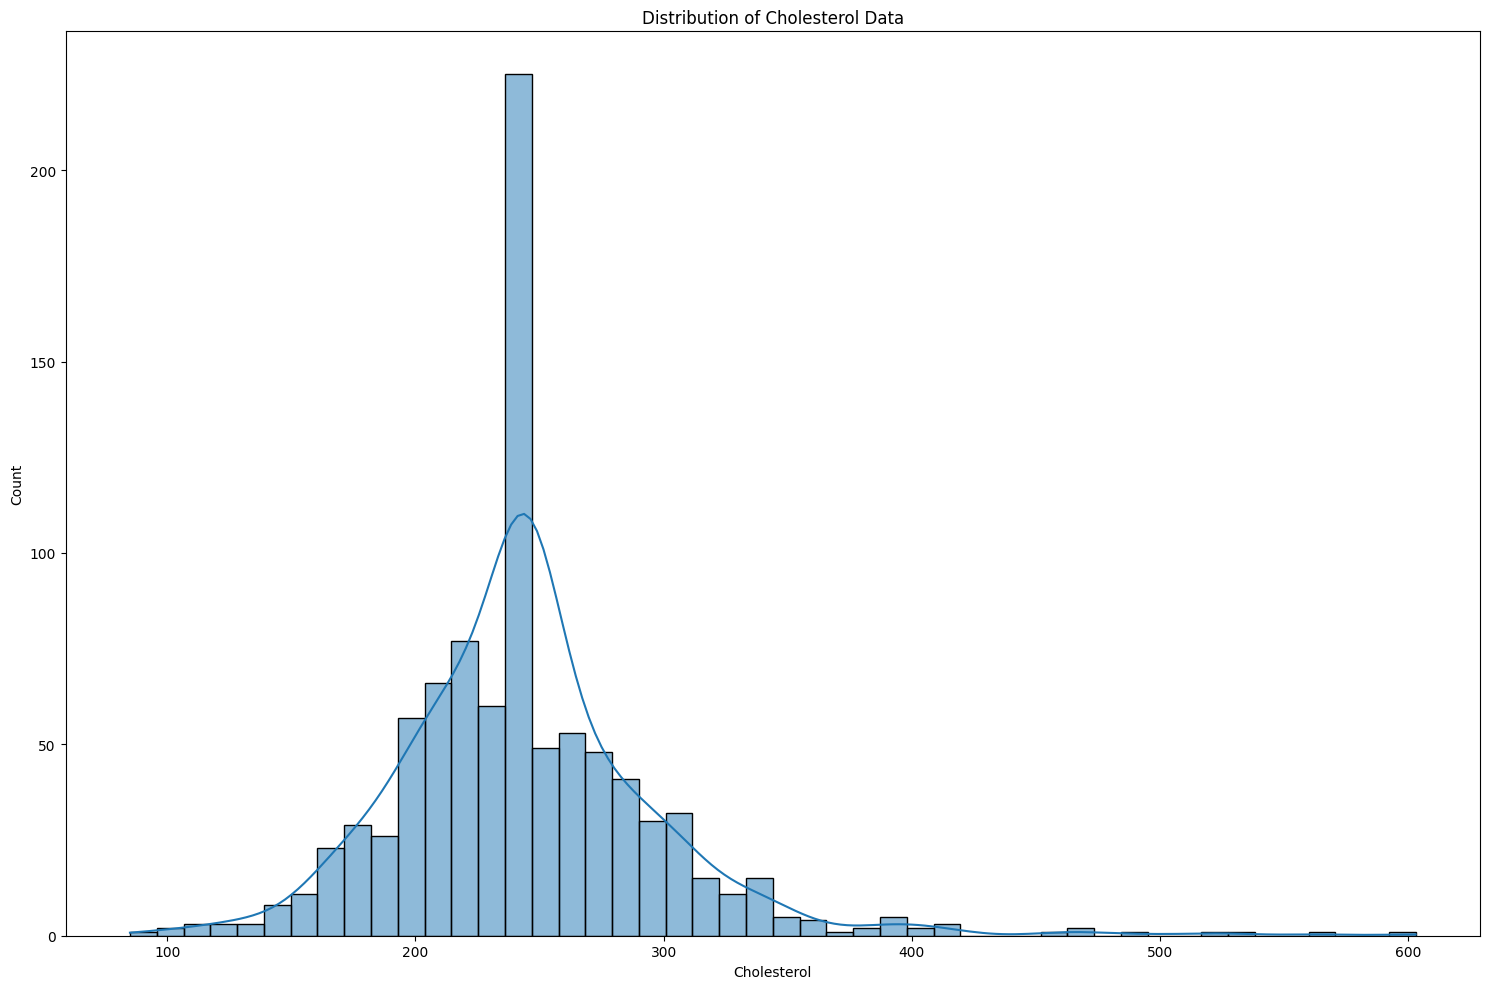

In [ ]:
plt.figure(figsize=(15,10))
plt.title(f"Distribution of Cholesterol Data")
sns.histplot(df['Cholesterol'],kde=True)
plt.tight_layout()
plt.plot()

It now much more look like a Gaussian plot.

In [ ]:
fig = px.box(df, y="Cholesterol", x="HeartDisease", title=f"Distribution of Cholesterol serum")
fig.show()

In this box plot, we see the distribution of Cholesterol values, we see here:
- Minimum (Whisker below)
- First quartile (Lower part of the rectangle)
- Median (Segment in the middle of the rectangle)
- Third quartile (Higher part of the rectangle)
- Maximum (Whisker above)

We notice a few extreme values that appear to be possible (see
[here](https://www.creapharma.ch/cholesterol.htm#gsc.tab=0)). So we should keep them as they are not wrong.

#### Scaling

Our ML model will not understand the units of the values of the features. So, we need to scale the data.

We have 2 options for data scaling : **Normalization or Standardization**.
Normalization is done for features whose data does not display normal distribution (gaussian) and standardization is for features that are normally distributed and where their values are huge or very small as compared to other features.

**Normalization**: Oldpeak feature should be normalized as it had displayed a right orientated data distribution.

**Standardization**: Age, RestingBP, Cholesterol and MaxHR features are scaled down because these features are normally distributed.


In [ ]:
standardScaler = StandardScaler()
df_test_scaling = df.copy()
df_test_scaling[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']] = standardScaler.fit_transform(df_test_scaling[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']])

normalizer = MinMaxScaler()
df_test_scaling[['Oldpeak']] = normalizer.fit_transform(df_test_scaling[['Oldpeak']])

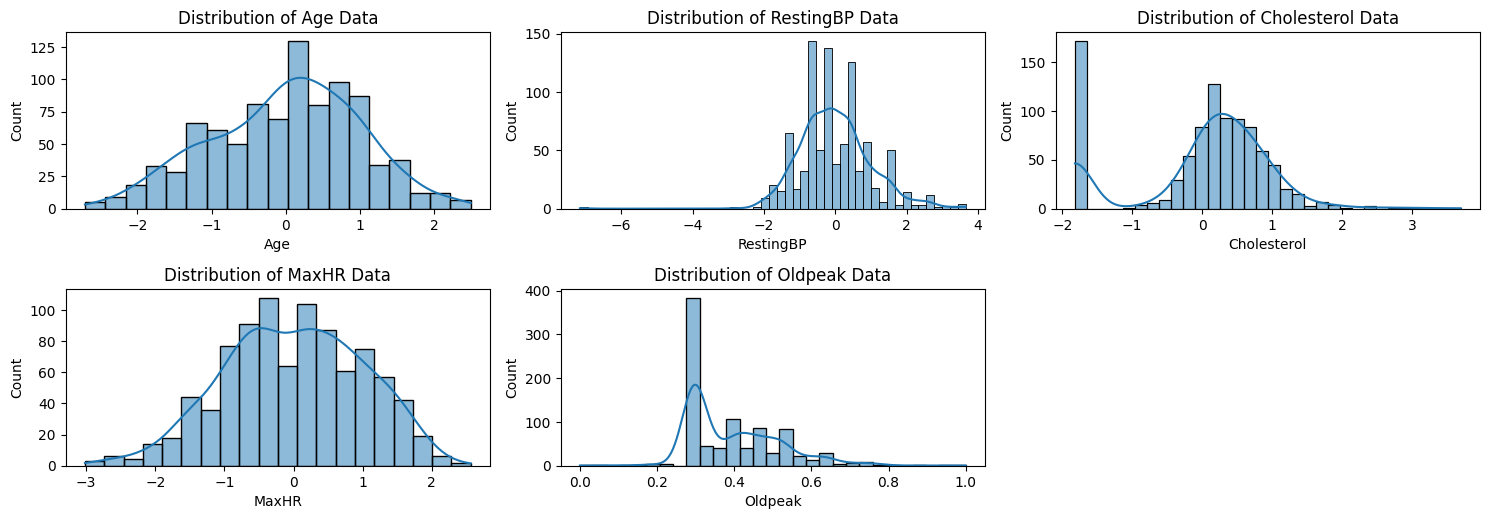

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df_test_scaling[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']],1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df_test_scaling[col],kde=True)
    plt.tight_layout()
    plt.plot()

### D - Target Feature Study

In our case, the target feature is the `HeartDecease` feature.

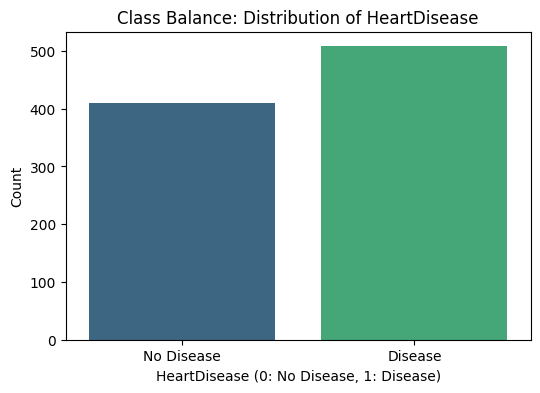

In [ ]:
plt.figure(figsize=(6, 4))
class_counts = df['HeartDisease'].value_counts()

# Assign the x variable to hue and disable the legend
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", dodge=False, legend=False)

plt.title("Class Balance: Distribution of HeartDisease")
plt.xlabel("HeartDisease (0: No Disease, 1: Disease)")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["No Disease", "Disease"])  # Optional for readability
plt.show()

`Note`: The class are balanced (400 without heart disease, 500 with heart disease). So no resampling is necessary. We can focus on accuracy, precision, recall and F1-score.

### E - Features Correlation & Selection

#### Features Correlation

We use `pairplot()` function to see relationship between a combination of variables in a dataframe.

[]

<Figure size 1500x1000 with 0 Axes>

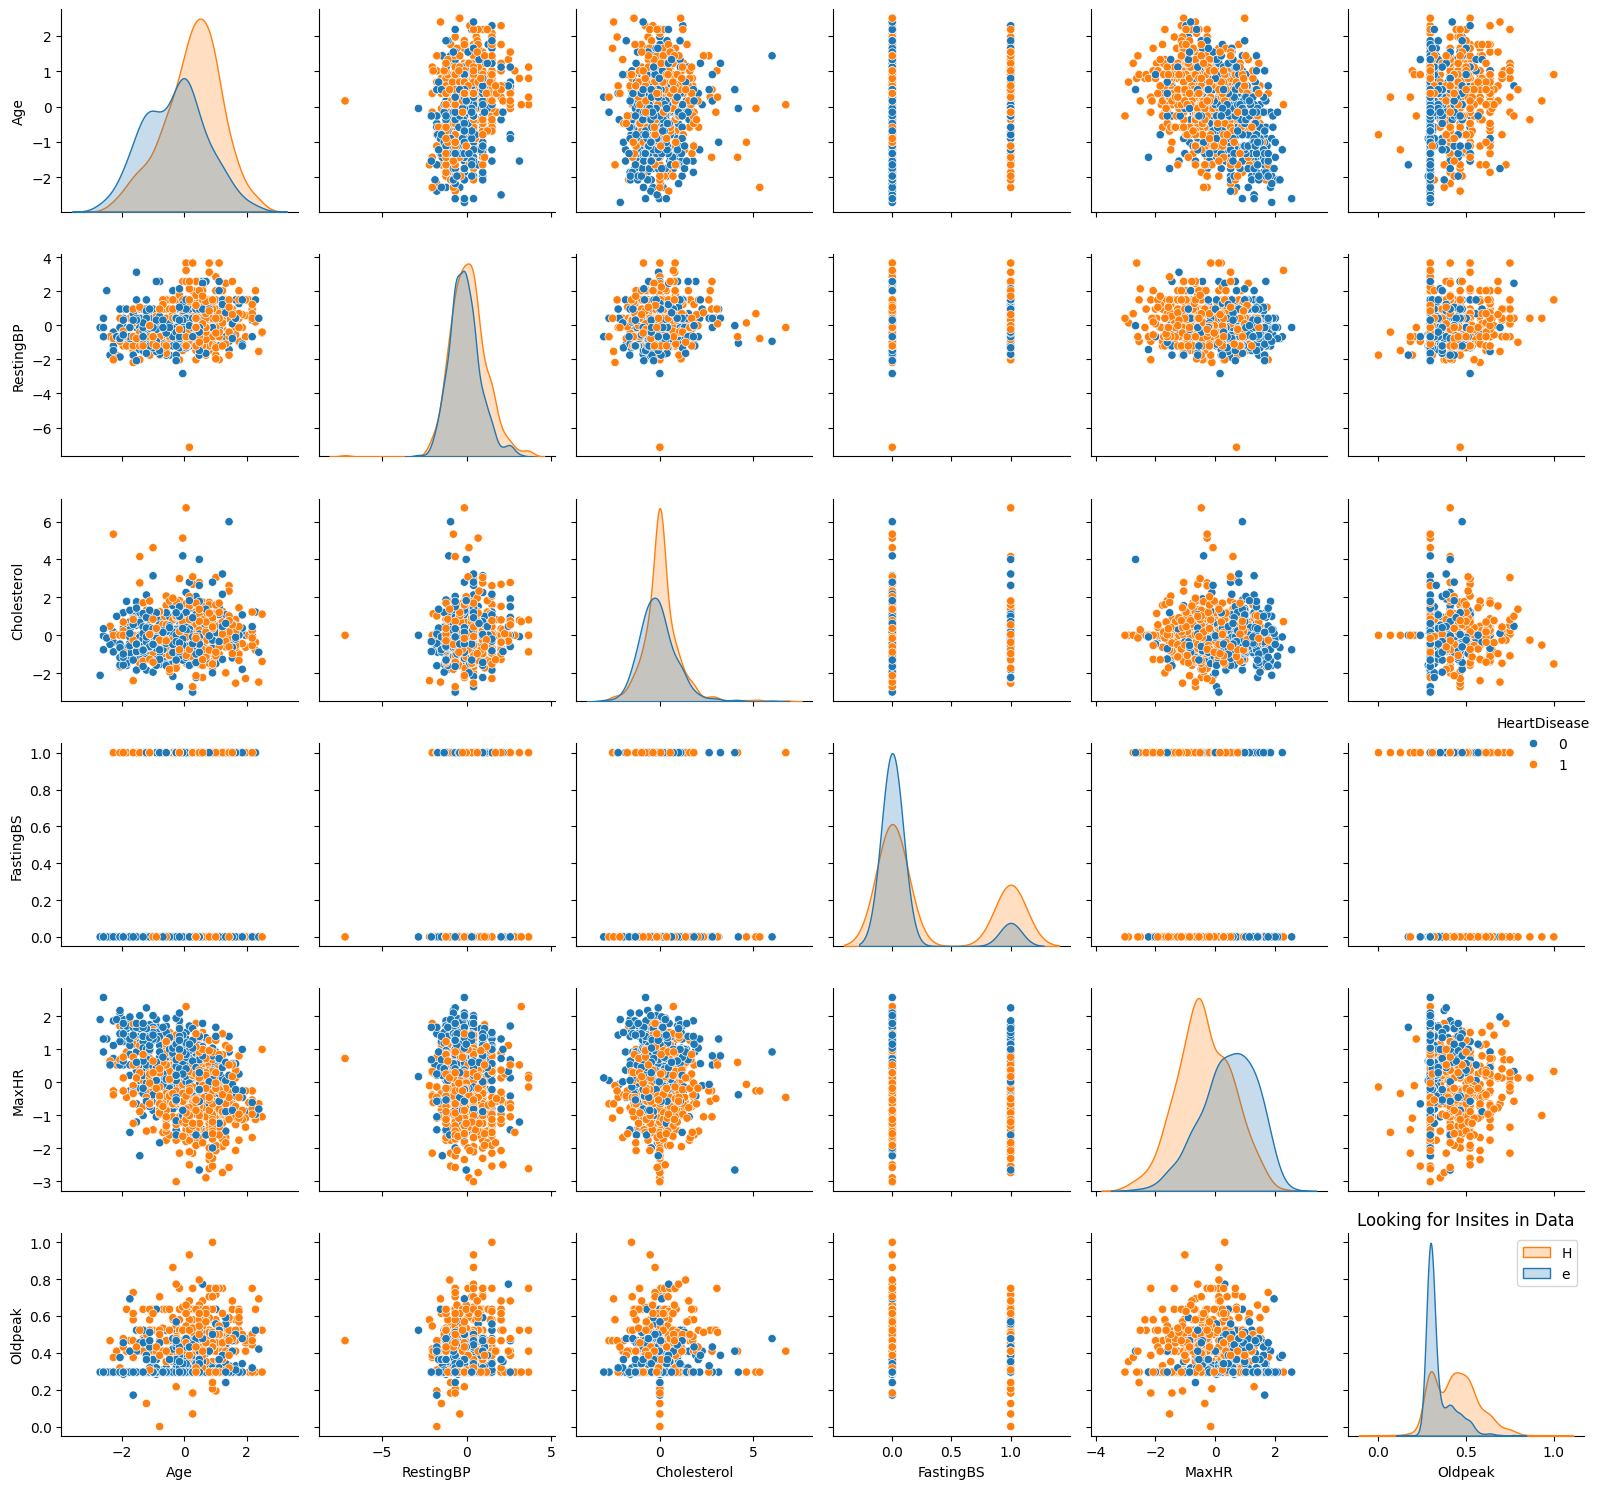

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

1. **Age**

`Observation`:
Older individuals are more likely to have heart disease, as evidenced by the greater density of orange points in the higher age ranges.

`Interpretation`:
Age is a significant factor in predicting heart disease.

2. **RestingBP**

`Observation`:
The distribution of RestingBP appears similar for individuals with and without heart disease.
There’s no clear separation between the two classes.
RestingBP values are mostly grouped around normal values (~120 mmHg) (see [here](https://www.bhf.org.uk/informationsupport/risk-factors/high-blood-pressure)).
We notice some outliers.

`Interpretation`:
RestingBP may not be a strong standalone predictor for heart disease.
Further analysis might be needed to determine its importance in combination with other features.
3. **Cholesterol**

`Observation`:
The cholesterol distribution has a notable overlap between the two classes (HeartDisease = 1 and HeartDisease = 0).
Extremely high cholesterol levels (>500 mg/dL) are rare but are present in both classes.
The presence of zero values are outliers.

`Interpretation`:
Cholesterol alone does not appear to be a strong discriminator between heart disease and no heart disease.
Extreme cholesterol levels are worth investigating further.
4. **FastingBS**

`Observation`:
More patients with heart disease have elevated fasting blood sugar.
The feature is balanced between the two classes.

`Interpretation`:
Elevated fasting blood sugar is a potential risk factor but may not be sufficient as a standalone feature for predicting heart disease.
It might interact with other variables (example: Age or Cholesterol).
5. MaxHR

`Observation`:
There is a negative correlation between Age and MaxHR, which is normal since heart rate decreases with age.
Patients with heart disease tend to have lower maximum heart rates compared to those without heart disease.

`Interpretation`:
MaxHR is probably a strong predictor for heart disease.
Reduced exercise capacity (lower MaxHR) is often associated with cardiovascular issues (see [here](https://pubmed.ncbi.nlm.nih.gov/32152731/)).
6. **Oldpeak**

`Observation`:
Patients with heart disease tend to have higher Oldpeak values compared to those without heart disease.
This feature shows better separation between the two classes compared to some others (maybe RestingBP).

`Interpretation`:
Oldpeak is a strong predictor for heart disease.
Higher values suggest greater ischemic changes during stress tests, which are indicative of heart disease.

In [ ]:
# Ordinal encoding for ST_Slope only because it is the only one in logical order
ordinal_encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded['ST_Slope'] = ordinal_encoder.fit_transform(df_encoded[['ST_Slope']])

# One hot encoder
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina'], drop_first=False)
correlation_matrix = df_encoded.corr()

In [ ]:
print(df_encoded.dtypes)

Age                    int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
MaxHR                  int64
Oldpeak              float64
ST_Slope             float64
HeartDisease           int64
Sex_F                   bool
Sex_M                   bool
ChestPainType_ASY       bool
ChestPainType_ATA       bool
ChestPainType_NAP       bool
ChestPainType_TA        bool
RestingECG_LVH          bool
RestingECG_Normal       bool
RestingECG_ST           bool
ExerciseAngina_N        bool
ExerciseAngina_Y        bool
dtype: object


In [ ]:
correlation_with_target = correlation_matrix['HeartDisease'].abs().sort_values(ascending=False).index
correlation_matrix_sorted = correlation_matrix.loc[correlation_with_target, correlation_with_target]
fig = px.imshow(correlation_matrix,
                title="Correlation Plot (Categorical + Numerical Features)",
                labels=dict(color="Correlation"),
                color_continuous_scale="Viridis")
fig.show()

#### Selection

**Numerical features**

1. **Age vs. MaxHR**:

`Observation / Interpretation`: The negative correlation between age and MaxHR is physiologically expected. This means these two variables provide complementary information and are not redundant.

`Decision`: Keep both variables.

2.  **Age vs. HeartDisease**:

`Observation / Interpretation`: Older patients are more likely to have heart disease, making Age an important variable for prediction.

`Decision`: Keep this variable.

3. **Oldpeak vs. HeartDisease**: Patients with heart disease tend to have higher Oldpeak values, making it a strong predictive feature.

`Decision`: Keep this variable.

- **Cholesterol vs. HeartDisease**:

`Observation / Interpretation`: The lack of clear separation between classes suggests cholesterol alone may not be a strong discriminator. However, it might be useful when combined with other variables since we know IRL that cholesterol has an impact on health conditions.

`Decision`: Retain for now but monitor its importance in the model.

**Categorical features**

1. **ST_Slope vs. HeartDisease**:

`Observation`: A strong positive correlation with HeartDisease, indicating that certain types of ST_Slope like "FLAT" are associated with a higher possibility of heart disease.

`Decision`: Keep ST_Slope as a key predictor.

2. **ChestPainType vs. HeartDisease**:

`Observation / Interpreation`: The “ASY” type is strongly positively correlated, whereas others are weakly correlated or even negatively associated.

`Decision`: Keep ChestPainType, as its categories contribute useful information.

3. **RestingECG vs. HeartDisease**:

`Observation / Interpreation`: The categories of RestingECG show weak to moderate correlations with HeartDisease. “ST” abnormalities appear slightly more predictive than other types like “Normal.” While RestingECG is not a strong standalone feature, its diagnostic importance in real-world scenarios justifies its inclusion.

`Decision`: Retain RestingECG for now but monitor its importance during feature selection in modeling.

4. **ExerciseAngina vs. HeartDisease**:

`Observation / Interpreation`: A strong correlation exists between ExerciseAngina and HeartDisease. Patients with “Y” (Yes) for ExerciseAngina are highly likely to have heart disease. This feature is highly relevant and aligns with real-world diagnostic insights.

`Decision`: Retain ExerciseAngina as a key feature.

5. **Sex vs. HeartDisease**:

`Observation / Interpreation`: There is a weak correlation between Sex (Male or Female) and HeartDisease. However, domain knowledge suggests that males are generally at higher risk of heart disease. Despite the weak correlation, Sex remains important for potential interaction effects with other features.

`Decision`: Retain Sex as a predictive feature.

## III - ML Baseline & Ensemble Models


### A - Training / Validation / Test Splits

1.	**Training Set (60%)**: This subset is used to train the model.
2.	**Validation Set (20%)**: This subset is used for hyperparameter tuning and model selection.
3.	**Test Set (20%)**: This subset is reserved for the final evaluation of the model’s performance.


In [ ]:
df.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,float64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


In [ ]:
# Separate features and target
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Initial train-test split (80% train + 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training set into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2 of original data


#### B - Pipelines & Models

In [ ]:
numerical_features_standard = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
numerical_features_minmax = ['Oldpeak']
ordinal_feature = ['ST_Slope']
# Already done
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']

numerical_transformer_standard = StandardScaler()
numerical_transformer_minmax = MinMaxScaler()
ordinal_transformer = OrdinalEncoder()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_std', numerical_transformer_standard, numerical_features_standard),
        ('num_minmax', numerical_transformer_minmax, numerical_features_minmax),
        ('ord', ordinal_transformer, ordinal_feature),
        ('cat', categorical_transformer, categorical_features)
    ]
)

NameError: name 'StandardScaler' is not defined

In [ ]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pipelines = {
    'Logistic Regression': logistic_pipeline,
    'Random Forest': rf_pipeline,
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"{name} Performance on Validation Set:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

NameError: name 'logistic_pipeline' is not defined

In [ ]:
for name, pipeline in pipelines.items():
    y_test_pred = pipeline.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"{name} Performance on Test Set:")
    print(f"Accuracy: {test_accuracy:.2f}")
    print(f"Precision: {test_precision:.2f}")
    print(f"Recall: {test_recall:.2f}")
    print(f"F1 Score: {test_f1:.2f}\n")

NameError: name 'pipelines' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_feature_names(preprocessor, numerical_features, ordinal_features, categorical_features):
    num_features = numerical_features
    ord_features = ordinal_features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    return np.concatenate([num_features, ['Oldpeak'], ord_features, cat_features])

feature_names = get_feature_names(preprocessor, numerical_features_standard, ordinal_feature, categorical_features)

rf_model = rf_pipeline.named_steps['model']
feature_importance = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()